In [1]:
# ! pip install --upgrade pandas


In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [3]:
print(tf.__version__)

2.16.1


In [4]:
data = pd.read_csv("convert_numeric.csv", delimiter=",")

In [5]:
data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,gender,marital_status,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0,6,1,3,1169,4,1,4,1,3,...,2,67,1,1,2,1,1,1,1,1
1,2,48,3,3,5951,0,2,2,0,1,...,2,22,1,1,1,1,1,0,1,0
2,3,12,1,9,2096,0,3,2,1,3,...,2,49,1,1,1,3,2,0,1,1
3,0,42,3,7,7882,0,3,2,1,3,...,0,45,1,0,1,1,2,0,1,1
4,0,24,2,1,4870,0,2,3,1,3,...,3,53,1,0,2,1,2,0,1,0


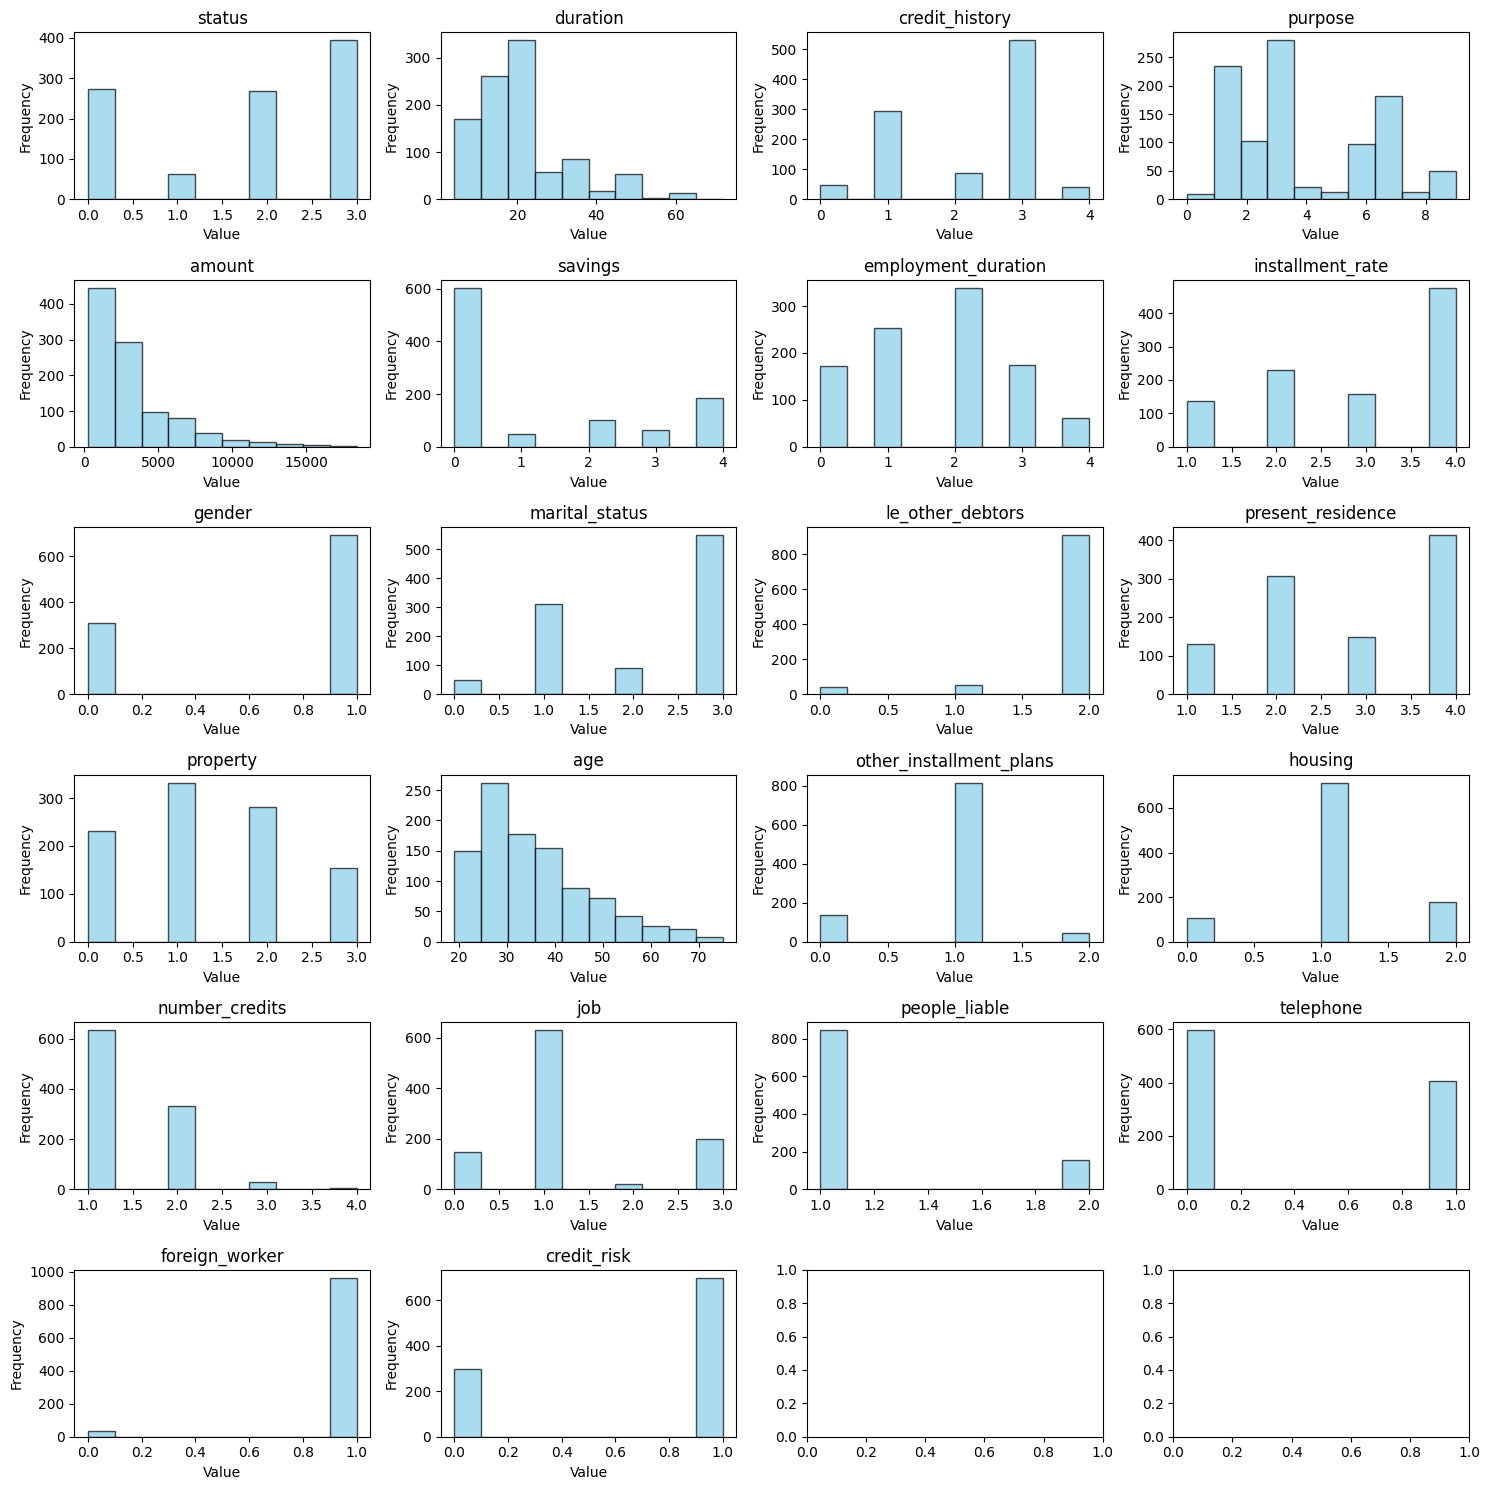

In [6]:
import matplotlib.pyplot as plt

# Assuming you have already loaded the data into 'data' using pd.read_csv

# Create a figure with subplots (6 rows, 4 columns)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Iterate over each column and create a histogram on a subplot
for i, column in enumerate(data.columns):
    axes[i].hist(data[column], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
X = data.drop('credit_risk', axis=1)  
y = data['credit_risk']

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.build(input_shape=(None, X.shape[1])) 
normalizer.adapt(X.values) 

X_normalized = normalizer(X) 



In [13]:
X_normalized

<tf.Tensor: shape=(1000, 21), dtype=float32, numpy=
array([[-1.4529533 , -1.2364779 , -1.146212  , ..., -0.4282895 ,
         1.2145976 ,  0.19601429],
       [ 0.17683169,  2.2481942 ,  0.7343654 , ..., -0.4282895 ,
        -0.8233179 ,  0.19601429],
       [ 0.9917242 , -0.7386675 , -1.146212  , ...,  2.334869  ,
        -0.8233179 ,  0.19601429],
       ...,
       [ 0.9917242 , -0.7386675 ,  0.7343654 , ..., -0.4282895 ,
        -0.8233179 ,  0.19601429],
       [-1.4529533 ,  1.9992892 ,  0.7343654 , ..., -0.4282895 ,
         1.2145976 ,  0.19601429],
       [ 0.17683169,  1.9992892 , -1.146212  , ..., -0.4282895 ,
        -0.8233179 ,  0.19601429]], dtype=float32)>

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'status'

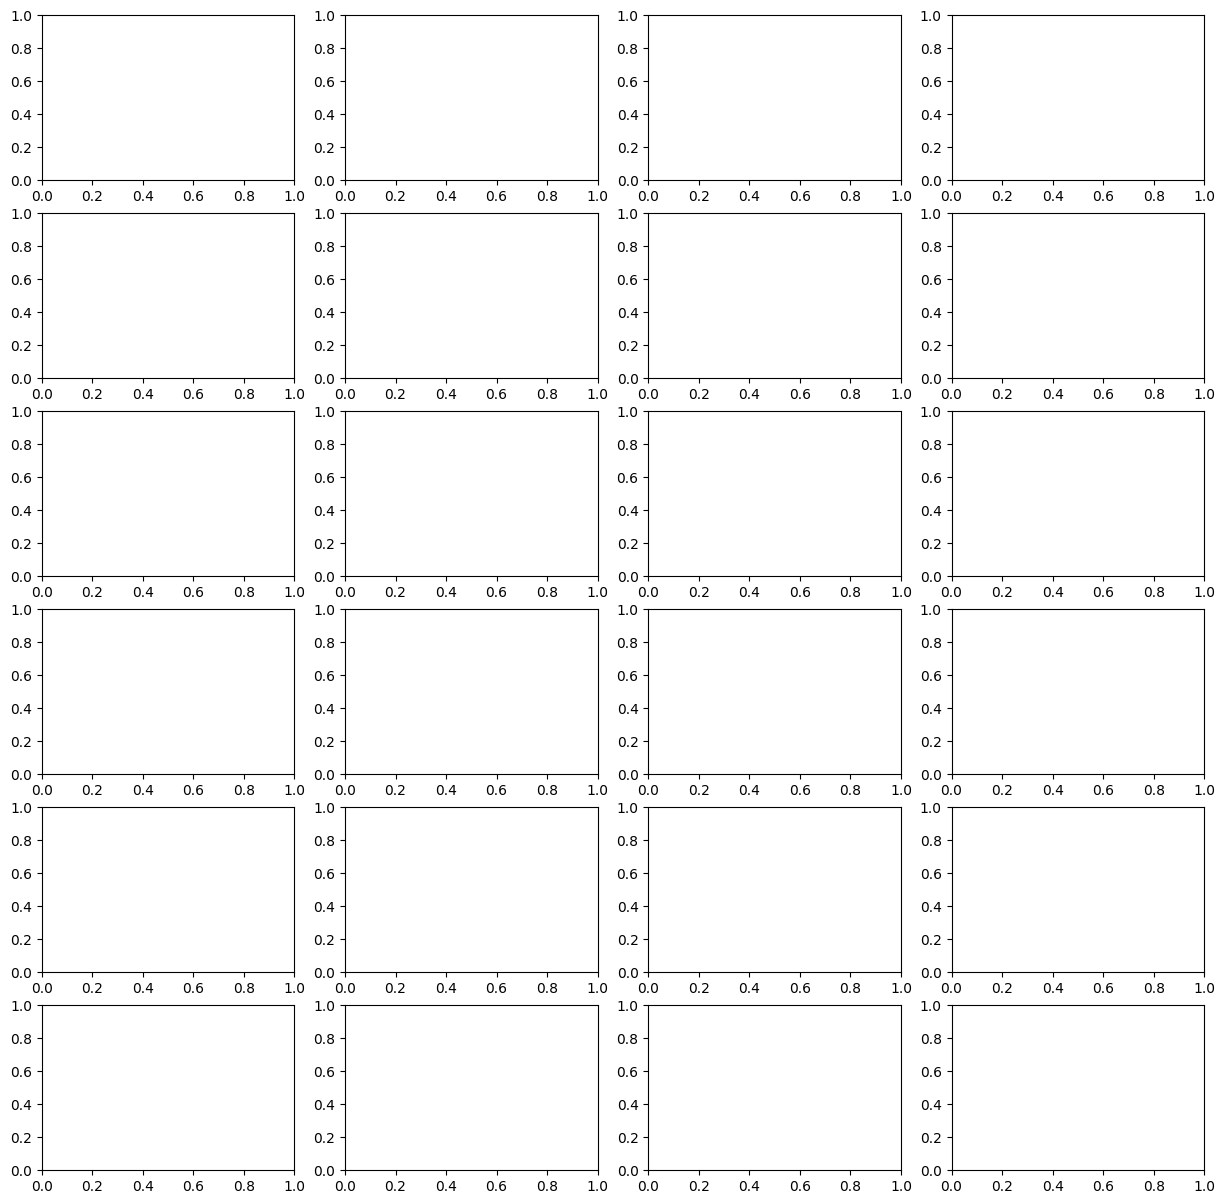

In [15]:
# Create a figure with subplots (6 rows, 4 columns)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Iterate over each column and create a boxplot on a subplot
for i, column in enumerate(data.columns):
    axes[i].boxplot(X_normalized[column], vert=False, patch_artist=True, showmeans=True, widths=0.5)  # Horizontal boxplot with mean marker
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Reshape X for the CNN: (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Make it 3D

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15


c:\Users\fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6250 - loss: 0.6509 - val_accuracy: 0.7050 - val_loss: 0.6076
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6816 - loss: 0.6321 - val_accuracy: 0.7050 - val_loss: 0.6081
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6764 - loss: 0.6345 - val_accuracy: 0.7050 - val_loss: 0.6043
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7093 - loss: 0.5986 - val_accuracy: 0.7050 - val_loss: 0.6054
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 0.6000 - val_accuracy: 0.7050 - val_loss: 0.5971
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6945 - loss: 0.6014 - val_accuracy: 0.7050 - val_loss: 0.5882
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6894 - loss: 0.5955 - val_accuracy: 0.7000 - val_loss: 0.5849
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6841 - loss: 0.5897 - val_accuracy: 0.7050 - val_loss: 0.5704
Ep

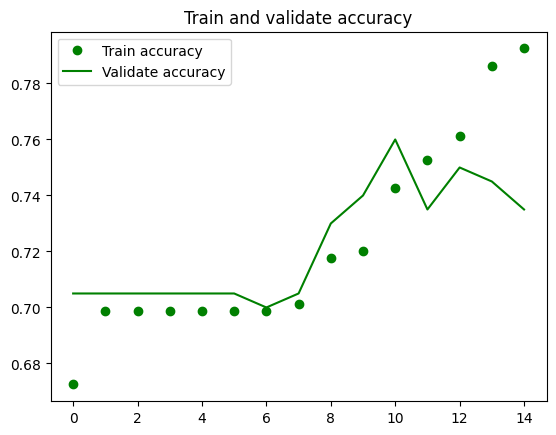

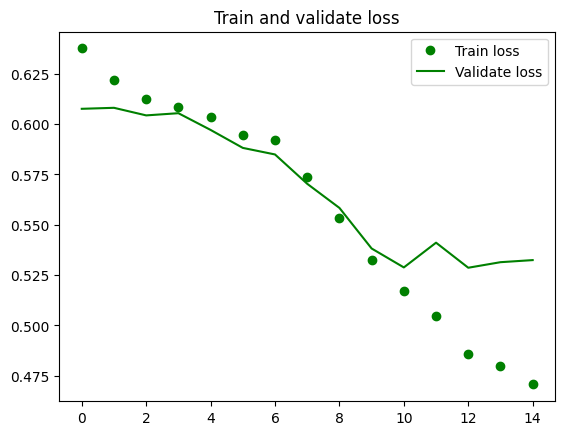

In [ ]:
acc = model.history.history['accuracy']                          
val_acc =  model.history.history['val_accuracy']
loss =  model.history.history['loss']
val_loss =  model.history.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show() 